In [33]:
#%pip install pyspark==3.5.0 python-dotenv requests pandas matplotlib seaborn plotly nbformat
%pip install nbformat>=4.2.0


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# 1. LOAD CREDENTIALS (Identical to Silver script)
# Since your notebook is in /notebooks, we go up one level to find .env
env_path = Path.cwd().parent / '.env'
load_dotenv(dotenv_path=env_path)

STORAGE_ACCOUNT = os.getenv("STORAGE_ACCOUNT")
CLIENT_ID       = os.getenv("CLIENT_ID")
TENANT_ID       = os.getenv("TENANT_ID")
CLIENT_SECRET   = os.getenv("CLIENT_SECRET")

# 2. BUILD THE SPARK SESSION
spark = SparkSession.builder \
    .appName("Aviation_EDA") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.4,com.microsoft.azure:azure-storage:8.6.6") \
    .config(f"fs.azure.account.auth.type.{STORAGE_ACCOUNT}.dfs.core.windows.net", "OAuth") \
    .config(f"fs.azure.account.oauth.provider.type.{STORAGE_ACCOUNT}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider") \
    .config(f"fs.azure.account.oauth2.client.id.{STORAGE_ACCOUNT}.dfs.core.windows.net", CLIENT_ID) \
    .config(f"fs.azure.account.oauth2.client.secret.{STORAGE_ACCOUNT}.dfs.core.windows.net", CLIENT_SECRET) \
    .config(f"fs.azure.account.oauth2.client.endpoint.{STORAGE_ACCOUNT}.dfs.core.windows.net", f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/token") \
    .getOrCreate()

# 3. LOAD THE DATA
silver_path = f"abfss://silver@{STORAGE_ACCOUNT}.dfs.core.windows.net/cleaned_flights"
df_silver = spark.read.parquet(silver_path)

# 4. PREVIEW
df_silver.limit(5).toPandas() # .toPandas() makes it look much nicer in Notebooks than .show()



:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-azure added as a dependency
com.microsoft.azure#azure-storage added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-19df8107-d7a5-458f-8cc6-c95da441974e;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-azure;3.3.4 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.hadoop.thirdparty#hadoop-shaded-guava;1.1.1 in central
	found org.eclipse.jetty#jetty-util-ajax;9.4.43.v20210629 in central
	found org.eclipse.jetty#jetty-util;9.4.43.v20210629 in central
	found org.codehaus.jackson#jackson-mapper-asl;1.9.13 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.F

,icao24,callsign,origin_country,time_position,last_contact,long,lat,baro_altitude,on_ground,velocity,true_track,vertical_rate,sensors,geo_altitude,squawk,spi,position_source,flight_time,processed_at
0,00b22b,SAA347,South Africa,1770995127,1770995135,19.7201,-33.1150,7879.08,False,187.49,235.96,-5.85,None,8275.32,None,False,0,2026-02-13 15:05:27,2026-02-13 16:00:50.715825
1,0d11c0,MXA1780,Mexico,1770995105,1770995105,-98.8568,19.8192,3665.22,False,159.47,115.41,15.61,None,3863.34,None,False,0,2026-02-13 15:05:05,2026-02-13 16:00:50.715825
2,0d11cc,VIV7812,Mexico,1770995155,1770995155,-98.9752,22.3322,11285.22,False,250.30,2.71,0.00,None,11917.68,None,False,0,2026-02-13 15:05:55,2026-02-13 16:00:50.715825
3,3455d8,VOE67SK,Spain,1770995156,1770995156,-2.2666,42.7450,10972.80,False,238.14,29.22,0.00,None,10751.82,1000,False,0,2026-02-13 15:05:56,2026-02-13 16:00:50.715825
4,39de46,TVF70CT,France,1770995156,1770995156,3.2525,48.7909,3649.98,False,183.73,91.60,0.65,None,3467.10,1000,False,0,2026-02-13 15:05:56,2026-02-13 16:00:50.715825


In [2]:
# How many flights total?
print(f"Total flights in Silver: {df_silver.count()}")

Total flights in Silver: 200


In [3]:
#top countries by flight count
country_counts = df_silver.groupBy("origin_country") \
    .count() \
    .orderBy("count", ascending = False)

country_counts.limit(10).toPandas()

,origin_country,count
0,United States,87
1,India,30
2,Turkey,16
3,France,11
4,Austria,9
5,Germany,8
6,Greece,7
7,Canada,6
8,Sweden,5
9,Estonia,4


In [4]:
#basic statistics for altitude and velocity
df_silver.select("baro_altitude", "velocity").describe().toPandas()

,summary,baro_altitude,velocity
0,count,178,199
1,mean,7255.267415730339,162.5317085427135
2,stddev,4220.83312948622,81.94112989691631
3,min,-53.34,0.0
4,max,13716.0,290.21


In [5]:
#filter for just the high flyers
cruising_flights = df_silver.filter(F.col("baro_altitude") > 10000)
print(f"Flights as cruising altitude: {cruising_flights.count()}")

Flights as cruising altitude: 80


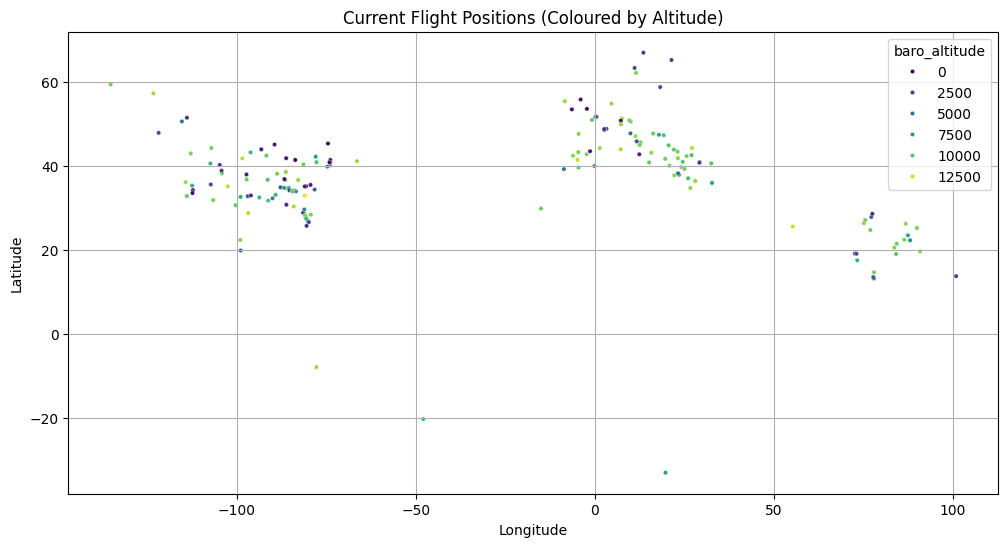

In [6]:
#visulaise the map - see where the planes are

import matplotlib.pyplot as plt
import seaborn as sns

#convert a sample to pandas for plotting
pdf = df_silver.select("long", "lat", "baro_altitude").toPandas()
#pdf

plt.figure(figsize=(12,6))
sns.scatterplot(data = pdf, x = "long", y="lat", hue="baro_altitude", palette="viridis", s=10)
plt.title("Current Flight Positions (Coloured by Altitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [7]:
import plotly.express as px
import nbformat

# 1. Convert Spark DF to Pandas
# We include more columns so we can see them when we hover our mouse over a dot
pdf = df_silver.select("long", "lat", "baro_altitude", "velocity", "callsign", "origin_country").toPandas()

# 2. Create the Map
fig = px.scatter_geo(pdf,
                     lat='lat',
                     lon='long',
                     color="baro_altitude", # Dots change color based on altitude
                     hover_name="callsign", # Shows flight number on hover
                     hover_data=["origin_country", "velocity"],
                     projection="natural earth",
                     title="Live Global Flights - Silver Layer",
                     color_continuous_scale=px.colors.sequential.Plasma)

# 3. Adjust the map look
fig.update_geos(
    showcountries=True, countrycolor="RebeccaPurple",
    showland=True, landcolor="LightGreen",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="Blue"
)

fig.show()

In [8]:
import plotly.express as px
import plotly.io as pio

#look at Europe only
# Filter the Spark DataFrame first
df_europe = df_silver.filter(
    (F.col("lat").between(35, 70)) & 
    (F.col("long").between(-25, 45))
)

#  Convert to Pandas
pdf_europe = df_europe.toPandas()

#  Create the Map
fig = px.scatter_geo(pdf_europe,
                     lat='lat',
                     lon='long',
                     color="baro_altitude",
                     hover_name="callsign",
                     hover_data=["origin_country", "velocity"],
                     scope="europe", # This tells Plotly to focus the camera on Europe
                     title="Live European Flight Traffic",
                     color_continuous_scale="Viridis")

#  Refine the visual details
fig.update_geos(
    resolution=50, # Higher detail for zoomed-in map
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="white",
    showocean=True, oceancolor="LightBlue",
    showlakes=True, lakecolor="Blue",
    showcountries=True
)

fig.update_layout(height=700, margin={"r":0,"t":50,"l":0,"b":0})

fig.show()